In [39]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from time import time
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Constantes
k_f, k_1, k_2, k_3, K_p = 28, 44, 26.5, 1.6, 0.18
R_1, r_2, R_3, r_4, R_5 = 6, 100, 50, 20, 1.6
V_p, J_leak = 1.2, 0.2

plt.rcParams.update({"font.size":20, "font.family":'Times New Roman'})

In [40]:
# Fonctions

def phi_1(c):
    """
        Calcul du taux phi_1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_1
    """
    return r_2 * c / (R_1 + c)
def phi_1_inv(c):
    """
        Calcul du taux phi_-1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_-1
    """
    return k_1 / (R_3 + c)
def phi_2(c):
    """
        Calcul du taux phi_2, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_2
    """
    return (k_2 + r_4*c) / (R_3 + c)
def phi_3(c):
    """
        Calcul du taux phi_3, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_3
    """
    return k_3 / (R_5 + c)

def J_pump(c):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
    Returns :
        J_Pump
    """
    return (V_p * c**2) / (K_p**2 + c**2)
def J_receptor(c,h,p,kf=k_f):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        kf : densité de récepteurs IP3 associé à chaque cellule
    Returns :
        J_Pump
    """
    return kf * ( (p*h*phi_1(c)) / (phi_1(c)*p + phi_1_inv(c)) )**4
def J_diffusion(c_1,c_2,D):
    """
        Calcul du taux de calcium diffusé entre deux cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
    Returns :
        J_Diffusion
    """
    return D*(c_2-c_1)

def J_diffusion2(c,interactions):
    """
        Calcul du taux de calcium diffusé entre plusieurs cellules
    Args :
        c : Concentration de calcium dans toutes les cellules (Matrice Nx1)
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
    Returns :
        J_Diffusion total pour chacune des cellules (Matrice Nx1)
    """
    return np.matmul(interactions,c)

def dc(c_1,c_2,h,p,D):
    """
        Équation différentielle du taux de variation de calcium pour un couplage de 2 cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        D : Force de diffusion entre deux cellules
    Returns :
        dc/dt
    """
    return J_receptor(c_1, h, p) - J_pump(c_1) + J_leak + J_diffusion(c_1, c_2, D)

def dh(c,h,p):
    """
        Équation différentielle d'ordre 1 décrivant la fraction de récepteurs InsP3 ouverts ou fermés.
    Args :
        c : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
    Returns :
        dh/dt
    """
    return phi_3(c) * (1-h) - (phi_1(c)*phi_2(c)*h*p) / (phi_1(c)*p + phi_1_inv(c))

def one_cell(t,hc,p):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans une cellule.
    Args :
        t : Variable d'évolution temporelle
        hc : couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second 
    Returns :
        Comportement du système au temps t
    """
    h, c = hc
    return [dh(c,h,p), dc(c,0,h,p,0)]

def multiple_cells(t,hc,interactions,p,kf,func_c_infuse):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans plusieurs cellules.
    Args :
        t : Variable d'évolution temporelle
        hc : Couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        func_c_infuse : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        Comportement du système à plusieurs cellules au temps t
    """
    h = hc[:len(hc)//2]
    c = hc[len(hc)//2:]
    # c += np.array([c_mod(t) for c_mod in func_c_infuse])
    dh_val = dh(c,h,p)
    dc_val = J_receptor(c,h,p,kf) - J_pump(c) + J_leak + J_diffusion2(c,interactions) + np.array([c_mod(t) for c_mod in func_c_infuse])
    all_val = list(dh_val) + list(dc_val)
    return all_val

def fill_interactions_matrix(interactions):
    """
        Remplissage de la matrice d'interactions. Elle doit être symétrique et la diagonale est la somme des autres éléments de la même ligne (ou colonne)
    Args :
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN incomplète)
    Returns :
        Matrice d'interaction remplie
    """
    for n in range(0,interactions.shape[0]):
        for m in range(n+1,interactions.shape[0]):
            interactions[m,n] = interactions[n,m]
    for n in range(interactions.shape[0]):
        interactions[n,n] = -np.sum(interactions[n,:])
    return interactions

def graph_format_ax(ax):
    """
        Remplissage de la matrice d'interactions. Elle doit être symétrique et la diagonale est la somme des autres éléments de la même ligne (ou colonne)
    Args :
        interactions : Matrice de la capacité d'échange entre toutes les cellules (Matrice NxN incomplète)
    Returns :
        Matrice d'interaction remplie
    """
    ax.tick_params(direction="in")
    

In [ ]:
# Comportement d'une cellule avec c_2 constant

DIM_C = [0,1,1000]
DIM_H = [0,1,1000]
p = 0.2333
D = 0

c_1 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_1 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
c_2 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_2 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
# c_2 = 0
H_1,C_1 = np.meshgrid(h_1,c_1)

# 0.243
for p in  [0.2429]:

    dc_1 = dc(C_1,0.9, H_1, p, D)
    dh_1 = dh(C_1,H_1,p)

    c_1_0 = 0.8
    h_1_0 = 0.2

    t_span = [0,1000]
    t = np.linspace(t_span[0],t_span[1],10000)

    sol = solve_ivp(one_cell,t_span,[h_1_0,c_1_0],dense_output=True, args=[p])
    h, c = sol.sol(t)
    plt.figure(figsize=(16,8))
    plt.streamplot(H_1, C_1, dh_1, dc_1, density=1, linewidth=0.5, arrowsize=0.6, broken_streamlines=False,color="black")
    plt.plot(h,c,color="red")
    plt.xlabel('h')
    plt.ylabel('c')
    plt.xlim(DIM_H[:2])
    # plt.xlim([0.5,0.85])
    plt.ylim(DIM_C[:2])
    plt.show()


In [41]:
def general(t_span, c0, h0, p, kf, interactions, c_mod):
    """
        Solutionne, pour toutes les cellules, le comportement dans le temps en plus des injections
    Args :
        t_span : Informations sur le temps d'échatillonage [Début, fin, nombre d'itérations]
        c0 : Concentrations initiales de toutes les cellules
        h0 : Fraction des récepteurs ouverts ou fermés initial pour toutes les cellules
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        interactions : Matrice de la capacité d'échange entre toutes les cellules (Matrice NxN incomplète)
        c_mod : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        solution de l'équation différentielle
    """
    t = np.linspace(t_span[0], t_span[1],t_span[2])
    interactions = np.array(interactions)/100
    interactions = fill_interactions_matrix(interactions)
    print(interactions)
    initial_values = np.array(h0+c0)

    sol = solve_ivp(multiple_cells,t_span[:2],y0=initial_values,dense_output=True, args=[interactions,p,kf,c_mod]).sol(t)
    # sol = solve_ivp(multiple_cells,t_span[:2],y0=initial_values,dense_output=True, args=[interactions,p,kf,c_mod],method="Radau").sol(t)
    return sol

def num_to_roman(n):
    """
        Converti un nombre format romain
    Args :
        n : Nombre à convertir
    Returns :
        Valeur de n en romain
    """
    # Ne devrait pas aller plus haut que 10 dans notre situation
    num = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X"]
    return num[n]

def graph_c_vs_t(sol, injections, N):
    """
        Trace le graphique de la concentration en fonction du temps de chacun des cellules
    Args :
        sol : Solution des équations différentielles de chacune des cellules
        injections : Liste des injections
        N : Nombre de cellules en jeu
    """
    colors = ["blue","orange","green","red","black"]
    fig, ax = plt.subplots(N,1,figsize=(16,8),sharex=True,sharey=True)
    for n in range(N):
        last_injection_index = 0
        for injection in injections:
            indices = np.where((t>=injection[1]-injection[2]/2) & (t<=injection[1]+injection[2]/2))
            ax[n].plot(t[last_injection_index:indices[0][0]],sol[N+n][last_injection_index:indices[0][0]],alpha=1,color=colors[n%len(colors)])
            ax[n].plot(t[indices],sol[N+n][indices],alpha=1,linestyle="dashed",color=colors[n%len(colors)])
            last_injection_index = indices[0][-1]
        ax[n].plot(t[last_injection_index:],sol[N+n][last_injection_index:],alpha=1,color=colors[n%len(colors)],label=f"$c_{n+1}$")
        ymin, ymax = ax[n].get_ylim()
        ax[n].set_ylim(0,ymax)
        for num,injection in enumerate(injections):
            ax[n].fill_between(x=[injection[1]-injection[2]/2,injection[1]+injection[2]/2], y1=ymax,y2=0,alpha=0.5,color="grey")
            ax[n].text(injection[1],ymax,f"{num_to_roman(num)}",horizontalalignment='center',verticalalignment='bottom')
        graph_format_ax(ax[n])
        ax[n].legend(loc="upper right")
    plt.xlabel("Temps [s]")
    plt.ylabel("Concentration c")
    plt.xlim([0,t_span[1]])
    # plt.legend()
    plt.show()

def animate_c_vs_h(N, sol):
    """
        Animation c vs h pour toutes les cellules
    Args :
        N : Nombre de cellules en jeu
        sol : Solution des équations différentielles de chacune des cellules
    """
    fig, ax = plt.subplots(figsize=(16,8))
    for n in range(N):
        plt.plot(sol[n],sol[N+n],label=f"$c_{n+1}$, $h_{n+1}$")
    plt.legend()
    points = []
    for n in range(N):
        points.append(ax.plot(sol[n][0],sol[N+n][0], marker="o")[0])
    def update(x):
        for n,point in enumerate(points):
            point.set_data([sol[n][x]],[sol[N+n][x]])
        return points
    ani = FuncAnimation(fig, update, interval=0.1, blit=True, repeat=True,
                        frames=100)
    plt.show()
    # ani.save("animation.gif")

[[-0.1   0.05  0.05]
 [ 0.05 -0.1   0.05]
 [ 0.05  0.05 -0.1 ]]


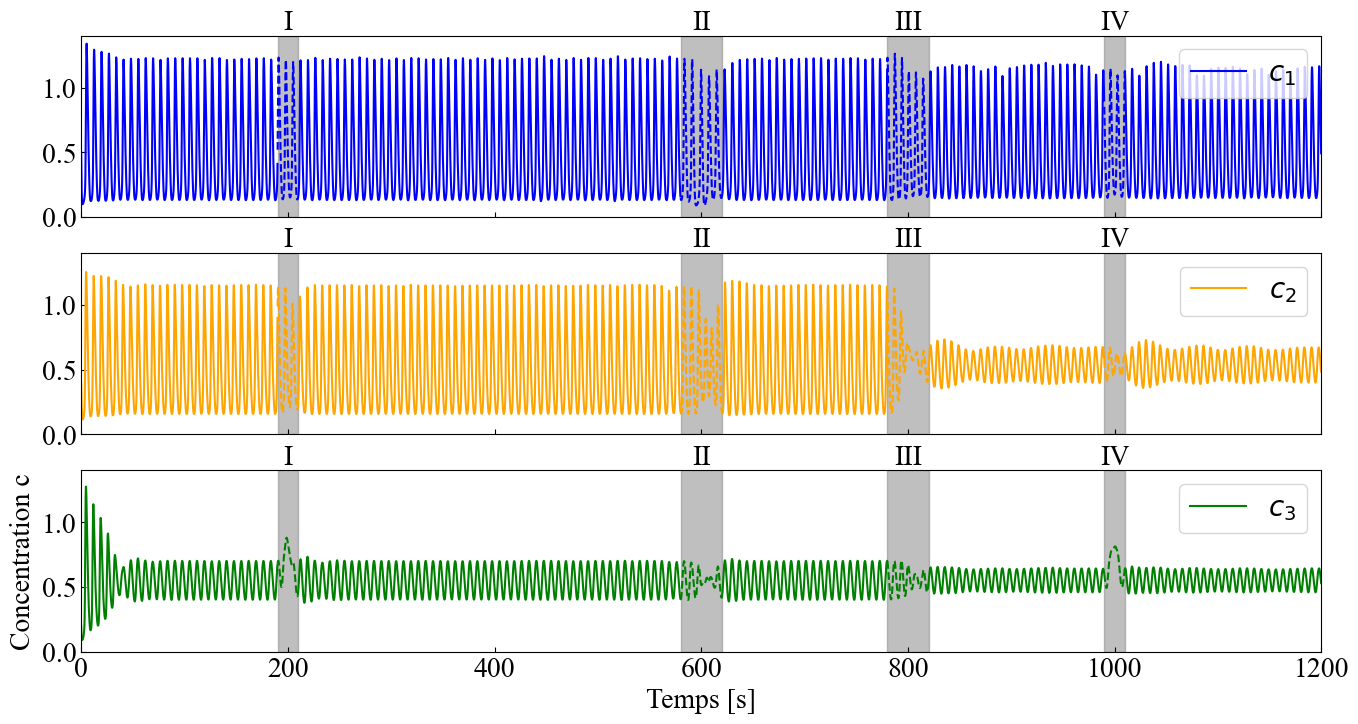

In [43]:
def injection_gauss(t, positions, widths, amps):
    """
        Injection avec une évolution de type gaussienne
    Args :
        t : temps
        positions : Position des gaussiennes
        width : Valeur de référence pour sigma en plus de limiter le domaine de chacune des gaussiennes
        amps : Amplitude des gaussiennes
    Returns :
        Valeur de l'injection au temps t
    """
    somme, valid = 0, False
    for pos, width,amp in zip(positions,widths,amps):
        if (t >= pos - width/2) and (t <= pos + width/2): valid = True
        somme += amp*np.exp(-0.5*((t-pos)/(width/6))**2)
    if valid: return somme
    else: return 0
N = 3
t_span = [0,1200,10000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]]

c0 = [0.5,0.4, 0.2]
h0 = [0.3,0.5, 0.1]

p = np.array([0.26,0.27,0.28])
kf = np.array([28,28,28])

injections = [["$c_3$",200,20,0.3], ["$c_1$",600,40,-0.1], ["$c_2$",800,40,0.1], ["$c_3$",1000,20,0.3]] # [No. cellule, temps d'injection, durée de l'injection, amplitude injection] dans l'ordre chronologique
c_mod = [lambda x: injection_gauss(x,[600],[40],[-0.1]), lambda x: injection_gauss(x,[800],[40],[0.1]), lambda x: injection_gauss(x,[200,1000],[20,20],[0.3,0.3])]
sol = general(t_span,c0,h0,p,kf,interactions,c_mod)
# animate_c_vs_h(N,sol)
graph_c_vs_t(sol, injections, N)



# Pour visualiser les temps d'injections
# t = np.linspace(0,100,1000)
# plt.plot(t,[injection_gauss(t_temp,[50,20],[20,20]) for t_temp in t])